## Redes Neuronales Informadas por Física
### Carrera de Especialización en Inteligencia Artificial - FIUBA

## Trabajo Práctico Nº1

### 3º Bimestre 2025

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |
| Ezequiel Maudet       | eze.maudet@gmail.com      | a1812   |
| Federico Zoya         | fzoya33@gmail.com         | a1828   |

### Flow in a Square Cavity (Lid-Driven Cavity)

#### Description:

This is a standard test case to verify the accuracy of numerical methods solving the incompressible Navier-Stokes equations. The domain is $\Omega = [0,1] \times [0,1]$

Governing equations in steady state:

- Momentum equation (vector form): $(\mathbf{u} \cdot \nabla) \mathbf{u} = - \nabla p + \frac{1}{Re} \nabla^2 \mathbf{u}$ in $\Omega$

- Continuity equation (incompressibility): $\nabla \cdot \mathbf{u} = 0$ in $\Omega$

Boundary conditions:  

- No-slip condition on the side and bottom walls (velocity zero).
- Top wall moves at a constant velocity in the ( +x ) direction.

### 1. LIBRARIES AND GENERAL PARAMETERS

In [1]:
import scipy.io                     # for matlab files manipulation
import os                           # for files manipulation
import pandas as pd                 # for data manipulation
import numpy as np                  # for data manipulation
import matplotlib.pyplot as plt     # for plotting


import torch                        # For neural networks models
from tqdm import tqdm               # For progress bar

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
import random

def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    # In general seed PyTorch operations
    torch.manual_seed(seed)

    # If you are using CUDA on 1 GPU, seed it
    torch.cuda.manual_seed(seed)

    # If you are using CUDA on more than 1 GPU, seed them all
    torch.cuda.manual_seed_all(seed)

    # Certain operations in Cudnn are not deterministic, and this line will force them to behave!
    torch.backends.cudnn.deterministic = True

    # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.
    torch.backends.cudnn.benchmark = False

set_seed(42)

#### 2. PROBLEM DEFINITION

In [4]:
# Domain definition
x_min = 0
x_max = 1

y_min = 0
y_max = 1

In [5]:
# Velocity boundary conditions

U_bc = [0, 0, 0, 1]     # [left, right, bot, top]
V_bc = [0, 0, 0, 0]     # [left, right, bot, top]

### 3. GROUND TRUTH SOLUTION

We load the reference solution obtained by finite element analysis.

In [6]:
folder = 'Re-100'

# Read all files in folder
files = os.listdir(folder)

# Filter only MatLab files
mat_files = [f for f in files if f.endswith('.mat')]

print(mat_files)

['pressure.mat', 'velocity.mat']


In [7]:
def mat2df(mat_file):
    """
    Load a .mat file and convert its variables into a pandas DataFrame.
    
    Parameters:
    - mat_file: str, path to the .mat file
    
    Returns:
    - df: pandas.DataFrame with variables as columns
    """
    file_path = os.path.join(folder, mat_file)
    data = scipy.io.loadmat(file_path)
    variables = {}
    for key in data:
        if not key.startswith('__'):
            value = data[key]
            # Convert scalar values to list
            if np.isscalar(value):
                variables[key] = [value]
            elif isinstance(value, np.ndarray):
                # Flatten array if necessary
                if value.ndim == 1:
                    variables[key] = value
                else:
                    variables[key] = value.flatten()
    # Create DataFrame
    df = pd.DataFrame(variables)
    return df

In [8]:
df_pressure = mat2df(mat_files[0])
df_pressure.head(5)

,x,y,z,p
0,0.00,0.0,0.0,0.000000
1,0.01,0.0,0.0,0.000016
2,0.02,0.0,0.0,0.000013
3,0.03,0.0,0.0,-0.000038
4,0.04,0.0,0.0,-0.000131


In [9]:
df_velocity = mat2df(mat_files[1])
df_velocity.head(5)

,x,y,z,u,v,w
0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.01,0.0,0.0,0.0,0.0,0.0
2,0.02,0.0,0.0,0.0,0.0,0.0
3,0.03,0.0,0.0,0.0,0.0,0.0
4,0.04,0.0,0.0,0.0,0.0,0.0


In [10]:
df_fem = pd.merge(df_pressure[['x', 'y', 'p']], df_velocity[['x', 'y', 'u', 'v']], on=['x', 'y'], how='inner')
df_fem.head(5)

,x,y,p,u,v
0,0.00,0.0,0.000000,0.0,0.0
1,0.01,0.0,0.000016,0.0,0.0
2,0.02,0.0,0.000013,0.0,0.0
3,0.03,0.0,-0.000038,0.0,0.0
4,0.04,0.0,-0.000131,0.0,0.0


In [11]:
ndata = df_fem.shape[0]
ndata

20201

Contour plot for the FEM results:

In [12]:
from scipy.interpolate import griddata

def contourplot_df(df, coord_cols, value_col, levels=50):
    # Extract node coordinates and nodal values
    points = df[['x', 'y']].values
    values = df[value_col].values

    # Create grid for plotting
    grid_x, grid_y = np.mgrid[
        points[:,0].min():points[:,0].max():100j,
        points[:,1].min():points[:,1].max():100j
    ]

    # Interpolate nodal values onto grid
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    # Plot the contour
    contour = plt.contourf(grid_x, grid_y, grid_z, levels=levels, cmap='turbo')
    plt.colorbar(contour)
    plt.title(f'FEM results contour plot of {value_col}')
    plt.xlabel(coord_cols[0])
    plt.ylabel(coord_cols[1])
    plt.axis('equal')
    # plt.show()

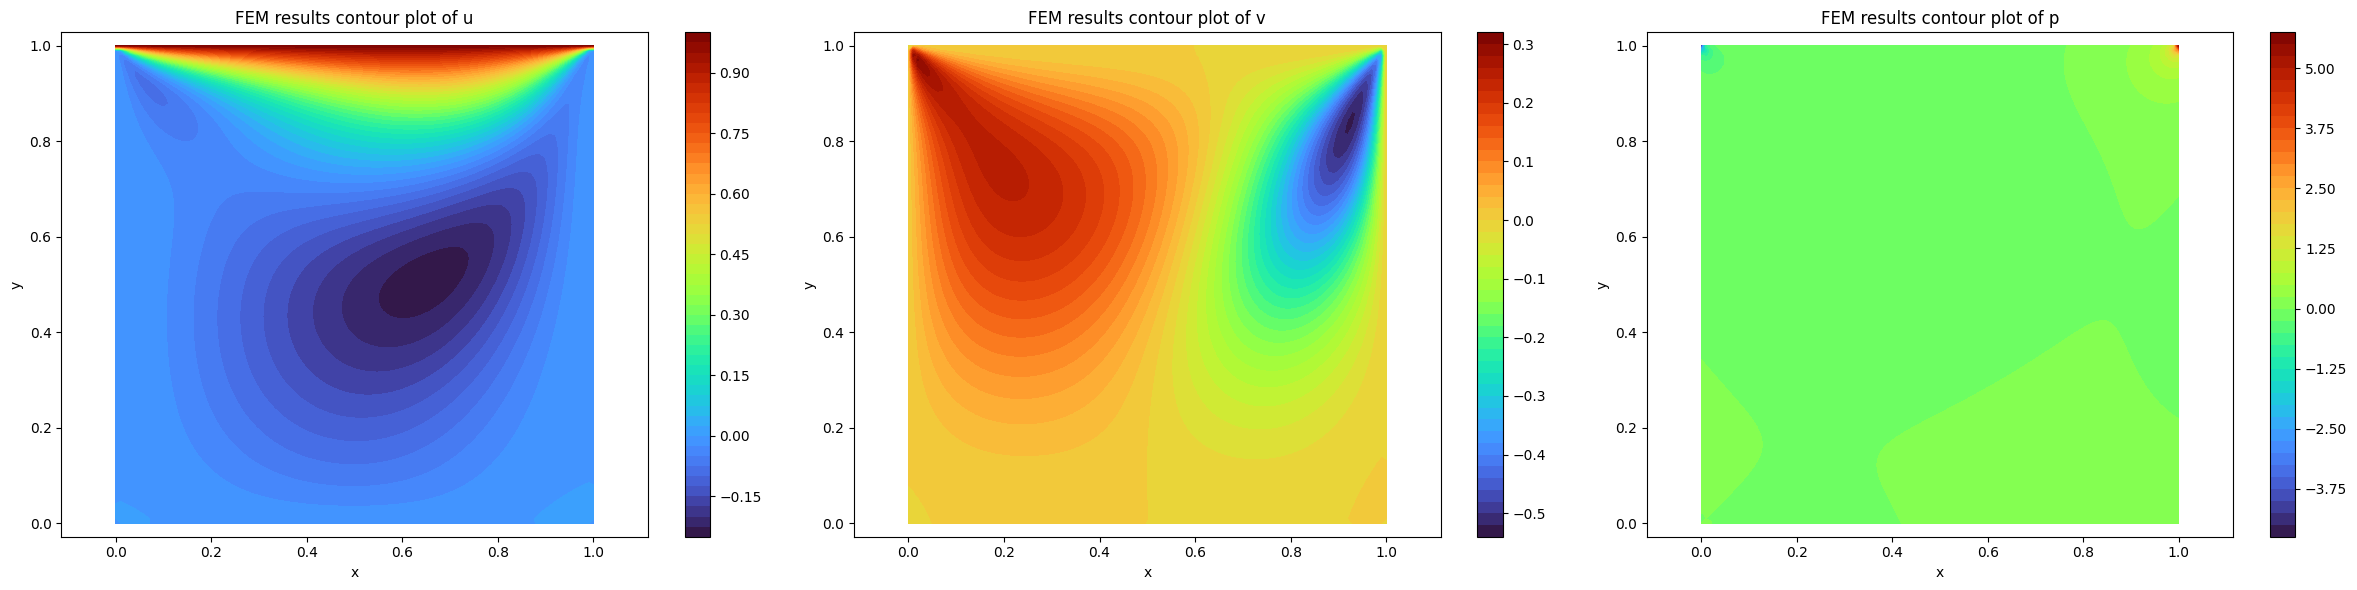

In [13]:
variables = ['u', 'v', 'p']
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for i, var in enumerate(variables):
    plt.sca(axes[i])
    contourplot_df(df_fem, ['x', 'y'], var)
    
for i, var in enumerate(variables):
    axes[i].set_title(f'FEM results contour plot of {var}')

plt.tight_layout()
plt.show()

### 4. DATA GENERATION

In [14]:
tags = ["Domain", "BoundaryConditions"]
isData = True           # Flag to indicate whether the analysis would use labelled data or not
nsamples = 10           # Number of labelled data to be used in the analysis

# Initialize list of dataset objects
ds_uniform = []
ds_random = []

#### 4.1 Collocation points

We generate two sets of collocation points: one inside the domain where the PDE residual will be evaluated, and the other along the boundaries where conditions will be enforced.

We define an auxiliary function capable to generate both uniform and randomly distribuited collocation points.

In [45]:
def get_collocation_points(x_min, x_max, y_min, y_max, n_pde, n_bc, n_res, n_out, random = True):
    """
    Generate collocation points for domain and boundary conditions.

    Args:
    - x_min, x_max: Minimum and maximum values for x-axis.
    - y_min, y_max: Minimum and maximum values for y-axis.
    - n_pde: Number of points for PDE domain.
    - n_bc: Number of points for each boundary.
    - random: Flag to choose between random and uniform distribution.
    - device: Device on which tensors should be allocated.

    Returns:
    - X_dom_tensor: Tensor containing the domain points.
    - X_bc_tensor: Tensor containing the boundary points.
    """
    if random:
        
        delta_x = x_max - x_min
        delta_y = y_max - y_min
        
        rand_aux = torch.rand((n_pde + 2 * n_bc, 2), device = device)
        
        x_dom = (x_min + delta_x * rand_aux[:n_pde, 0]).to(torch.float32)
        y_dom = (y_min + delta_y * rand_aux[:n_pde, 1]).to(torch.float32)
        
        y_left = (y_min + delta_y * rand_aux[n_pde:(n_pde + n_bc), 1]).to(torch.float32)
        y_right = (y_min + delta_y * rand_aux[-n_bc:, 1]).to(torch.float32)
    
        x_bot = (x_min + delta_x * rand_aux[n_pde:(n_pde + n_bc), 0]).to(torch.float32)
        x_top = (x_min + delta_x * rand_aux[-n_bc:, 0]).to(torch.float32)

    else:
        # Adjust n_pde for uniform case
        n_pde_sqrt = int(np.sqrt(n_pde))
        n_pde = n_pde_sqrt**2
        
        # Crear una cuadrícula 2D de tamaño n_pde x n_pde
        x_vals = torch.linspace(x_min, x_max, n_pde_sqrt, device=device)
        y_vals = torch.linspace(y_min, y_max, n_pde_sqrt, device=device)
        X_grid, Y_grid = torch.meshgrid(x_vals, y_vals, indexing='ij')

        # Aplanar las mallas en vectores 1D si quieres usar en los datos
        x_dom = X_grid.reshape(-1)
        y_dom = Y_grid.reshape(-1)    
        
        y_left = torch.linspace(y_min, y_max, n_bc, device = device)
        y_right = y_left.clone()
        
        x_bot = torch.linspace(x_min, x_max, n_bc, device = device)
        x_top = x_bot.clone()

    x_left = x_min * torch.ones(n_bc)
    x_right = x_max * torch.ones(n_bc)
    
    y_bot = y_min * torch.ones(n_bc)
    y_top = y_max * torch.ones(n_bc)

    # Combine all domain points
    X_dom_tensor = torch.stack((x_dom, y_dom), dim=1)

    # Combine all boundary points
    X_bc_tensor = torch.cat([
                torch.stack((x_left, y_left), dim=1),
                torch.stack((x_right, y_right), dim=1),
                torch.stack((x_bot, y_bot), dim=1),
                torch.stack((x_top, y_top), dim=1),
            ], axis=0)

    Y_dom_tensor = torch.zeros((n_pde, n_res), device=device)
    Y_bc_tensor = torch.zeros((4 * n_bc, n_out), device=device)
    print
    return X_dom_tensor, Y_dom_tensor, X_bc_tensor, Y_bc_tensor

In [47]:
from torch.utils.data import TensorDataset

# Number of collocation points
n_pde = 1_000       # for domain
n_bc = 100          # for Boundary conditions

X_dom_uniform_tensor, Y_dom_uniform_tensor, X_bc_uniform_tensor, Y_bc_uniform_tensor = get_collocation_points(x_min, x_max, y_min, y_max, n_pde, n_bc//4, n_res = 2, n_out = 3, random = False)
X_dom_rand_tensor, Y_dom_rand_tensor, X_bc_rand_tensor, Y_bc_rand_tensor= get_collocation_points(x_min, x_max, y_min, y_max, n_pde, n_bc//4, n_res = 2, n_out = 3, random = True)

ds_uniform.append(TensorDataset(X_dom_uniform_tensor, Y_dom_uniform_tensor))
ds_uniform.append(TensorDataset(X_bc_uniform_tensor, Y_bc_uniform_tensor))

ds_random.append(TensorDataset(X_dom_rand_tensor, Y_dom_rand_tensor))
ds_random.append(TensorDataset(X_bc_rand_tensor, Y_bc_rand_tensor))


#### 4.2 Boundary Conditions

In [17]:
u_tensors = [ui * torch.ones((n_bc, 1)) for ui in U_bc]
v_tensors = [vi * torch.ones((n_bc, 1)) for vi in V_bc]

u_bc_tensor = torch.cat(u_tensors, axis=0)
v_bc_tensor = torch.cat(v_tensors, axis=0)

#### 4.3 Labelled data

In [18]:
if isData:
    tags.append("LabelledData")
    idx_data = np.random.choice(range(ndata), nsamples, replace=False)
    
    data_np = df_fem.iloc[idx_data].to_numpy()                      # Convert df to numpy
    data_tensor = torch.from_numpy(data_np).float().to(device)      # Convert numpy to torch tensor

    X_data = data_tensor[:, :2]     # columns (x, y)
    Y_data = data_tensor[:, 2:]     # columns (p, u, v)

    ds_uniform.append(TensorDataset(X_data, Y_data))
    ds_random.append(TensorDataset(X_data, Y_data))

**RESPUESTA PUNTO 3**

La inclusión de datos rotulados le permite al modelo combinar información de la física a través de las ecuaciones de gobierno con la información de datos "reales" resultando en un modelo más robusto. 

En términos prácticos, los puntos rotulados actúan como un refuerzo del aprendizaje supervisado, mientras que los puntos de colocación garantizan la consistencia de la solución física en todo el dominio.

El dataset de datos rotulados se complementa con el par de datasets del dominio y de la condición de borde.

#### 4.4 Plot grid

In [19]:
# Dictionary of dataset objects
datasets_uniform = dict(zip(tags, ds_uniform))
datasets_random = dict(zip(tags, ds_random))

In [20]:
def plot_grid(dataset, title = None):
    # Plot the locations of the collocation points in the space domain
    X_dom = (dataset["Domain"][:][0]).data.cpu().numpy()
    X_bc = (dataset["BoundaryConditions"][:][0]).data.cpu().numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X_dom[:,0], X_dom[:, 1], s=4, c='r', label=f'N_dom={len(X_dom)}')
    ax.scatter(X_bc[:, 1:2], X_bc[:, 0:1], s=4, c='b', label=f'N_bc={len(X_bc)}')
    if isData:
        X_data = (dataset["LabelledData"][:][0]).data.cpu().numpy()
        ax.scatter(X_data[:, 0], X_data[:, 1], s=30, c='g', label=f'N_Data={len(X_data)}', marker='*')
    ax.legend()
    plt.xlabel('X-coord')
    plt.ylabel('Y-coord')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    if title is not None:
        plt.title(title)
    plt.show()

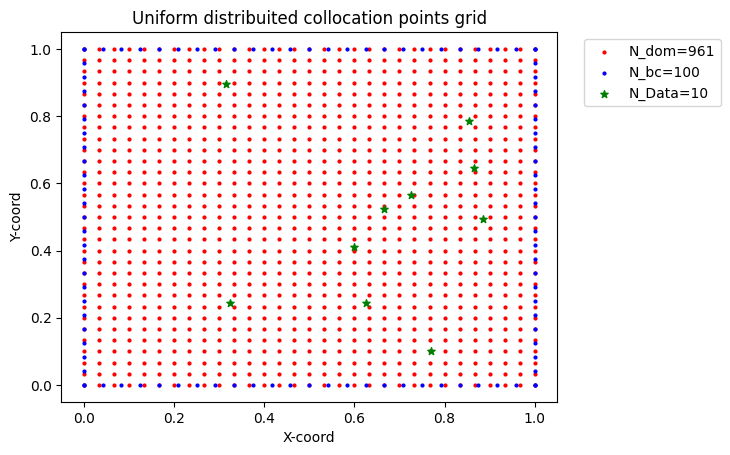

In [21]:
plot_grid(datasets_uniform, title='Uniform distribuited collocation points grid')

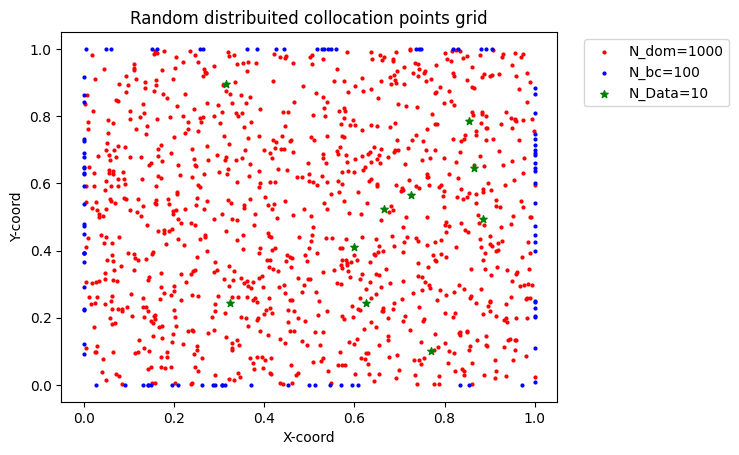

In [22]:
plot_grid(datasets_random, title='Random distribuited collocation points grid')

**RESPUESTA PUNTO 4**

Las fronteras físicas del dominio forman parte del dominio y, por ende, ahí también se tienen que cumplir las ecuaciones que gobiernan la física del problema, lo cual se hace mínimizando el residuo en los puntos de colocación. Por lo tanto, el sub-conjunto de puntos de colocación dentro del dominio donde la PDE va a ser resuelta debe incluir las fronteras físicas a los efectos de forzar las ecuaciones de gobierno del problema en esas regiones. En paralelo, se debe definir un sub-conjunto de puntos sobre las fronteras físicas en donde las  condiciones de borde están prescriptas. Adicionalmente, si el problema fuese *time-dependent¨*, se deberá definir otro sub-conjunto de puntos a lo largo de la coordenada temporal.

### 5. PINN IMPLEMENTATION

Implementamos la solución usando PyTorch.

#### 5.1 Model architecture

Definimos una FC NN que toma las coordenadas espaciales *(x,y)* como inputs y devuelve los campos velocidades *u*,*v* y presión como outputs.

- **INPUTS**:
    1. Position vector x-component *x*
    2. Position vector x-component *x*

- **OUTPUTS**:
    1. Velocity vector x-component *u*
    2. Velocity vector y-component *v*
    3. Pressure scalar *p*

In [56]:
import torch.nn as nn
import torchinfo as torchinfo

# Neural Network
class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters.Device
        self.Xmin = model_parameters.Xmin
        self.Xmax = model_parameters.Xmax
        self.Ymin = model_parameters.Ymin
        self.Ymax = model_parameters.Ymax
        self.Reynolds = model_parameters.Reynolds
        self.InputDimensions = model_parameters.InputDimensions
        self.OutputDimensions = model_parameters.OutputDimensions
        self.NumberOfNeurons = model_parameters.NumberOfNeurons
        self.NumberOfHiddenLayers = model_parameters.NumberOfHiddenLayers
        self.ActivationFunction = model_parameters.ActivationFunction
        self.Bias = model_parameters.Bias
        
        # Input layer
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        # Hidden layers
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons, bias = self.Bias) for _ in range(self.NumberOfHiddenLayers - 1)])
        # Output layer
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions, bias = self.Bias)
        
        self.init = getattr(model_parameters, 'init', None)
        if self.init is None:
            pass
        elif self.init == 'xavier':
            self.init_xavier()
        elif self.init == 'he':
            self.init_he()
        else:
            raise ValueError("Invalid initialization method. Choose 'xavier', 'he', or None.")
        
    def forward(self, inputs):
        x_lb = self.Xmin
        x_ub = self.Xmax
        y_lb = self.Ymin
        y_ub = self.Ymax

        x, y = inputs[:, 0:1], inputs[:, 1:2]
        
        x_normalized = 2*(x - x_lb)/(x_ub - x_lb) - 1        # Normalized between [-1, 1]
        y_normalized = 2*(y - y_lb)/(y_ub - y_lb) - 1        # Normalized between [-1, 1]
        
        X = torch.cat([x_normalized, y_normalized], axis=1)
        output = self.ActivationFunction(self.InputLayer(X))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def init_xavier(self):
        def init_weights(m):
            if isinstance(m, nn.Linear) and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def init_he(self):
        def init_weights(m):
            if isinstance(m, nn.Linear) and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('relu')
                torch.nn.init.kaiming_uniform_(m.weight, a=g, mode='fan_in', nonlinearity='relu')
                m.bias.data.fill_(0)

        self.apply(init_weights)


    def ContinuityResidual(self, X, u, v):
        # Compute the derivatives of the output w.r.t. the inputs (space) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        ux = diff_u[:, 0:1]
        
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        vy = diff_v[:, 1:2]
        
        # Continuity equation residual
        res = ux + vy
        
        return res
    
    def MomentumResidual(self, X, u, v, p):
        Re = self.Reynolds

        # Compute the derivatives of the output w.r.t. the inputs (space) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        ux, uy = diff_u[:, 0:1], diff_u[:, 1:2]

        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        vx, vy = diff_v[:, 0:1], diff_v[:, 1:2]
        
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        px, py = diff_p[:, 0:1], diff_p[:, 1:2]
        
        # Compute the second derivative of velocity vector w.r.t. the inputs (space) using AD mechanism:
        uxx = torch.autograd.grad(ux, X, create_graph=True, grad_outputs=torch.ones_like(u))[0][:, 0:1]
        uyy = torch.autograd.grad(uy, X, create_graph=True, grad_outputs=torch.ones_like(u))[0][:, 1:2]
        
        vxx = torch.autograd.grad(vx, X, create_graph=True, grad_outputs=torch.ones_like(v))[0][:, 0:1]
        vyy = torch.autograd.grad(vy, X, create_graph=True, grad_outputs=torch.ones_like(v))[0][:, 1:2]      

        # Momentum equation residual
        res = [
            u * ux + v * uy + px - Re * (uxx + uyy),
            u * vx + v * vy + py - Re * (vxx + vyy)
        ]
        return res

#### 5.2 Definition of training functions

In [57]:
# Loss function
loss_function = nn.MSELoss()

In [58]:
from sklearn.metrics import accuracy_score

def calculate_metric(y, y_pred):
    metric = accuracy_score(y)
    return metric

In [63]:
def train_one_epoch(datasets, tags, model, optimizer, scheduler):
    # Lists to store loss
    loss_list = []
    tag_keys = []

    # Zero the parameter gradients
    optimizer.zero_grad()
    
    for tag in tags:
        X = (datasets[tag][:][0]).to(device)
        y = (datasets[tag][:][1]).to(device)
        if tag=='Domain':           # If "Domain", we enforced the PDE governing equations
            X.requires_grad = True
            output = model(X)
            u = output[:, 0:1]
            v = output[:, 1:2]
            p = output[:, 2:3]
            
            y_hat_continuity = model.ContinuityResidual(X, u, v)
            loss_continuity = loss_function(y_hat_continuity, y[:,0])

            y_hat_momentum = model.MomentumResidual(X, u, v, p)
            loss_momentum = loss_function(y_hat_momentum, y[:,1])

            loss = loss_continuity + loss_momentum
            
        else:   # If "BoundaryConditions" or "LabelledData", we enforced the boundary conditions or the labelled data       
            y_hat = model(X)
            loss = 0
            for i in range(model.OutputDimensions):
                loss += loss_function(y_hat[:,i], y[:,i])
        
        loss_list.append(loss)
        tag_keys.append(tag)

    loss = sum(loss_list)
        
    # Backprop and optimize
    loss.backward()
    optimizer.step()

    # Step the scheduler
    scheduler.step()

    loss_list.insert(0, loss_momentum)
    tag_keys.insert(0, "Momentum")
    loss_list.insert(0, loss_continuity)  
    tag_keys.insert(0, "Continuity")
    loss_list.insert(0, loss)
    tag_keys.insert(0, "Overall")

    return dict(zip(tag_keys, loss_list))


In [64]:
def validate_one_epoch(datasets, model):
    # Set model to evaluation mode
    model.eval()

    X = (datasets['LabelledData'][:][0]).to(device)
    y = (datasets['LabelledData'][:][1]).to(device)

    with torch.no_grad():
        y_hat = model(X)
        loss = 0
        metric = 0
        for i in range(model.OutputDimensions):
            loss += loss_function(y_hat[:,i], y[:,i])
            metric += calculate_metric(y[:,i], y_hat[:,i])

    return {
        'loss': loss,
        'metric': metric,
    }

In [65]:
def fit(model, optimizer, scheduler, tags, train_datasets, valid_datasets=None):
    # Lists to store metrics for training and validation
    train_losses = []
    val_losses = []
    val_metrics = []
    
    for epoch in range(cfg.epochs):
        print(f"Epoch {epoch + 1}/{cfg.epochs}")

        # Train for one epoch
        train_results = train_one_epoch(train_datasets, tags, model, optimizer, scheduler)
        print(f"Train Loss: {train_results['Overall']:.4f}")
        print(f"Continuity Train loss: {train_results['Continuity']:.4f} Momentum Train loss: {train_results['Momentum']:.4f}")
        print(f"PDE Train loss: {train_results['Domain']:.4f} BC Train loss: {train_results['BoundaryConditions']:.4f}")
        if isData:
            print(f"Labelled Data Train Loss: {train_results['LabelledData']:.4f}")
        
        # Store training losses
        train_losses.append(train_results)

        if valid_datasets:
            # Validation step
            val_results = validate_one_epoch(valid_datasets, model)
            print(f"Val Loss: {val_results['loss']:.4f}")
            print(f"Val accuracy: {val_results['metric']:.4f}")

            # Store validation metrics
            val_metrics.append(val_results['metric'])
            val_losses.append(val_results['loss'])
            
    return train_losses, val_losses, val_metrics

#### 5.5 Hyperparameter tunning

In [61]:
# Input Object for model instance
cfg.Device = device
cfg.Xmin = x_min
cfg.Xmax = x_max
cfg.Ymin = y_min
cfg.Ymax = y_max
cfg.Reynolds = 100
cfg.InputDimensions = 2
cfg.OutputDimensions = 3
cfg.Bias = True
cfg.lr_min = 1e-5
cfg.ActivationFunction = nn.ReLU()

In [66]:
import optuna

def objective(trial):
    lr  = trial.suggest_float('lr', 1e-4, 1e-2)             # Learning rate
    nneurons = trial.suggest_int('nneurons', 10, 50)        # Number of neurons
    nhidden = trial.suggest_int('nhidden', 4, 64)
    
    cfg.learning_rate  = lr
    cfg.NumberOfNeurons = nneurons
    cfg.NumberOfHiddenLayers = nhidden
    
    # Instanciamos la red
    pinn_model = PINN_Module(cfg).to(device)
    
    # Run training loop and return final loss
    cfg.epochs = 20
    
    optimizer = torch.optim.Adam(
                            pinn_model.parameters(),
                            lr = cfg.learning_rate,
                            weight_decay = 0,
                        )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max = cfg.epochs,
                eta_min = cfg.lr_min
                )
    
    #fitting the model on training data and record the result after each epoch
    train_losses, _, _ = fit(pinn_model, optimizer, scheduler, tags, datasets_random, valid_datasets=None)

    return train_losses[-1]['Overall']

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best hyperparameters:", study.best_params)

[I 2025-07-14 13:06:02,840] A new study created in memory with name: no-name-ef2f4b50-7016-4006-8e88-127df007ca28
c:\Users\badesia\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[W 2025-07-14 13:06:02,862] Trial 0 failed with parameters: {'lr': 0.009868447486597048, 'nneurons': 46, 'nhidden': 10} because of the following error: AttributeError("'list' object has no attribute 'size'").
Traceback (most recent call last):
  File "c:\Users\badesia\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\badesia\AppData\Local\Temp\ipykernel_8

Epoch 1/20


AttributeError: 'list' object has no attribute 'size'

We generate a *config* object in order to modify parameters during numerical experimentation.

In [32]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

In [34]:
# Model construction
model = PINN_Module(cfg).to(device)

# Print the model architecture
print(torchinfo.summary(model))


AttributeError: 'types.SimpleNamespace' object has no attribute 'NumberOfNeurons'

Definimos una función de entrenamiento por epoch. Primeramente, cálculamos por separado la función de pérdida asociada a la ecuación de continuidad y a la ecuación de momentum con el objetivo de poder monitorear en forma independiente como van evolucionando a través del entrenamiento. Al final, sumamos ambas pérdidas para tener un valor general del problema.

In [ ]:
def plot_history(train_f1, train_loss, val_f1, val_loss, title=None):
    # Extract species and health metrics for train_f1
    train_species = [epoch['species_metric'] for epoch in train_f1]
    train_health = [epoch['health_metric'] for epoch in train_f1]
    # Extract species and health metrics for val_f1
    val_species = [epoch['species_metric'] for epoch in val_f1]
    val_health = [epoch['health_metric'] for epoch in val_f1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Loss
    ax[0].plot(range(len(train_loss)), train_loss, color='darkgrey', label='train')
    ax[0].plot(range(len(val_loss)), val_loss, color='cornflowerblue', label='validation')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend(loc='upper right')

    # Plot F1 scores
    ax[1].plot(range(len(train_species)), train_species, label='Species Train', color='blue')
    ax[1].plot(range(len(train_health)), train_health, label='Health Train', color='cyan')
    ax[1].plot(range(len(val_species)), val_species, label='Species Validation', color='red')
    ax[1].plot(range(len(val_health)), val_health, label='Health Validation', color='orange')
    ax[1].set_title('F1 scores')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(loc='upper right')

    if title:
        plt.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()

#### 5.4 Training

In [ ]:
filename = 'best_pinn_model.pth'

if os.path.exists(filename):
    state_dict = torch.load('./' + filename, map_location=cfg.device)
    best_model.load_state_dict(state_dict)

else:
  cfg.epochs = 100

  optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

  best_model = best_model.to(cfg.device)
  train_f1, train_loss, val_f1, val_loss = fit(baseline,
                                              optimizer,
                                              scheduler,
                                              cfg,
                                              train_loader,
                                              val_loader)

  plot_history(train_f1, train_loss, val_f1, val_loss, title = 'Baseline #1: Simple CNN')

  # Save the trained model

  torch.save(best_model.state_dict(), filename)

  if IN_COLAB:  # Download the file
      from google.colab import files
      files.download(filename)

#### 2.3 Best CNN Model

In [ ]:
# Recover best parameters
lr = study.best_params['lr']
n_conv_layers = study.best_params['n_conv_layers']
n_hidden_layers = study.best_params['n_hidden_layers']
kernel = study.best_params['kernel']

print(f'Learning Rate: {lr}')
print(f'Number of Convolutional Layers: {n_conv_layers}')
print(f'Number of Hidden Layers: {n_hidden_layers}')
print(f'Kernel Size: {kernel}')

# CNN parameters
n_channels = 1
last_cout = 4
inputs_by_conv_layer = [n_channels, last_cout]
for i in range(n_conv_layers-1):
    inputs_by_conv_layer.append(last_cout * 2)
    last_cout *= 2

# FCNN Hidden parameters
last_hout = 64
inputs_by_hidden_layer = [last_hout]
for i in range(n_hidden_layers-1):
    inputs_by_hidden_layer.append(last_hout * 2)
    last_hout *= 2

# Instanciamos la red
best_cnn_model = CNN_EmotionClassifier(inputs_by_conv_layer,
                    inputs_by_hidden_layer,
                    n_outputs = nclasses,
                    kernel = kernel,
                    in_height = in_height,
                    in_width = in_width,
                    )

In [ ]:
import torchinfo as torchinfo

torchinfo.summary(best_cnn_model)

In [ ]:
num_epochs = 30
patience = 10
opt_func = torch.optim.Adam
#fitting the model on training data and record the result after each epoch
history = fit(best_cnn_model, train_loader, val_loader, num_epochs, patience, lr, opt_func)  

#### 5.5 Testing the model

In [ ]:
# Test step
test_result = validate_one_epoch(test_loader, baseline, cfg)
print(f"Test Loss: {test_result['loss']:.4f}")
print(f"Species Test F1: {test_result['species_metric']:.4f} Health Test F1: {test_result['health_metric']:.4f}")

In [ ]:
def predict(dataloader, model, cfg):
    model.eval()  # Modo evaluación

    final_species = []
    final_health = []

    # Iterar sobre los datos
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)

        with torch.no_grad():
            # Forward pass
            species_logits, healthy_logits = model(X)

            # Predicciones
            pred_species = torch.argmax(species_logits, dim=1)
            pred_health = torch.sigmoid(healthy_logits).squeeze()

            # Convertir predicciones a listas y acumular
            final_species.extend(pred_species.cpu().numpy())
            final_health.extend(pred_health.cpu().numpy())

    # Devolver como diccionario o lista
    return {
        'species': np.array(final_species),
        'health': (np.array(final_health) > 0.5).astype(int)
    }


# Usar la función predict con la instancia del modelo
y_pred_base = predict(test_loader, baseline, cfg)

# Recuperar las etiquetas verdaderas del set de test
species_labels = []
health_labels = []

for _, labels in test_loader:
    species_labels.extend(labels['species'].cpu().numpy())
    health_labels.extend(labels['health'].cpu().numpy())

y_test_species = np.array(species_labels)
y_test_health = np.array(health_labels)

In [ ]:
# # Fitting stage
# t0 = datetime.now()
# data_time_now = datetime.now().strftime("%d%m%Y_%H%M%S")

# Training parameters
epochs = 100            # cantidad de epochs
patience = 10           # early stopping patience

# List initialization
loss_train = []
loss_train_dom = []
loss_train_bc = []
loss_train_data = []

# Early Stopping parameters
best_val_loss = float('inf')
patience_counter = 0

train_keys = ['Overall', 'Domain', 'BC', 'IC', 'Data']

for epoch in range(epochs):

    ############################################
    ## TRAINING
    ############################################

    loss_list = []
    optimizer.zero_grad()
    for tag in tags:
        X = (datasets[tag][:][0]).to(device)
        y = (datasets[tag][:][1]).to(device)
        if tag=='Domain':
            X.requires_grad = True
            T = model(X)
            y_hat = model.internalEnergyBalanceResidue(X, T)
            loss = loss_fn(y_hat, y)
            loss_list.append(loss)

        else:
            T = model(X)
            loss = loss_fn(T, y)
            loss_list.append(loss)

    loss = sum(loss_list)
    # Backpropagation step
    loss.backward()
    optimizer.step()

    loss_list.insert(0, loss)
    loss_train.append(loss_list[0].item())
    loss_train_dom.append(loss_list[1].item())
    loss_train_bc.append(loss_list[2].item())
    if isData:
        loss_train_data.append(loss_list[4].item())

    if epoch % 100 == 0:
        log_dict = dict(zip(train_keys, loss_list))
        aux = "".join(f"{key}: {value:.5e}, " for key, value in log_dict.items())
        optimizer_str = type(optimizer).__name__
        print(f"##TRAIN## {optimizer_str} - Epoch: {epoch}, " + aux)

elapsed_time_train = datetime.now() - t0
print("\nTraining Time: ", elapsed_time_train.seconds, "[s]")

NameError: name 'datasets' is not defined

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Grafica loss por epoch
ax1.plot(train_loss_by_epoch, label="Train set")
ax1.plot(val_loss_by_epoch, label="Validation set")
ax1.legend()
ax1.set_title("Loss by Epoch: NN without Embeddings")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Cross Entropy")
ax1.grid()

# Gráfica de precisión por epoch
ax2.plot(train_acc_by_epoch, label="Train Accuracy", color='red')
ax2.plot(val_acc_by_epoch, label="Validation Accuracy", color='blue')
ax2.legend()
ax2.set_title("Accuracy by Epoch: NN without Embeddings")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid()

plt.tight_layout()
plt.show()